## xbgoost
- 커널: [Xtreme Boost and feature engineering](https://www.kaggle.com/krishonaveen/xtreme-boost-and-feature-engineering)
- 모델링보다는 전처리가 중요해 보임. lightGBM으로도 해 보기
- **참고**: 모델링에 필요한 데이터 타입은 **반드시** int, float or bool

In [1]:
import numpy as np
import pandas as pd
import os, warnings
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk("../input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input\df_id.pkl
../input\df_pca.pkl
../input\df_test.pkl
../input\df_train.pkl
../input\df_trans.pkl
../input\sample_submission.csv
../input\test.pkl
../input\test_0823.pkl
../input\test_identity.csv
../input\test_transaction.csv
../input\train_0823.pkl
../input\train_identity.csv
../input\train_transaction.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [4]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
        end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
import gc

In [4]:
train = pd.read_pickle("../input/df_train.pkl") #memory 줄인 버전
test = pd.read_pickle("../input/df_test.pkl")
sample_submission = pd.read_csv("../input/sample_submission.csv",
                               index_col = "TransactionID")
# df_test = df_test.merge(sample_submission, how='left', left_index=True,
#                          right_index=True, on='TransactionID')

In [5]:
print(train.shape) #왜 커널보다 컬럼이 한개씩 많지?
print(test.shape)

(590540, 434)
(506691, 433)


In [6]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [7]:
cols_to_drop=['V300','V309','V111','C3','V124','V106','V125','V315','V134','V102','V123','V316','V113',
              'V136','V305','V110','V299','V289','V286','V318','V103','V304','V116','V29','V284','V293',
              'V137','V295','V301','V104','V311','V115','V109','V119','V321','V114','V133','V122','V319',
              'V105','V112','V118','V117','V121','V108','V135','V320','V303','V297','V120']

print("{} features are going to be dropped for being useless".format(
len(cols_to_drop)))

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

50 features are going to be dropped for being useless


In [8]:
len(train.columns) #384

384

In [9]:
def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()

isFraud   P_emaildomain    NoFraud      Fraud  count      perc
38       protonmail.com  59.210526  40.789474     76  0.012870
29             mail.com  81.037567  18.962433    559  0.094659
36           outlook.es  86.986301  13.013699    438  0.074169
0               aim.com  87.301587  12.698413    315  0.053341
35          outlook.com  90.541601   9.458399   5096  0.862939
21           hotmail.es  93.442623   6.557377    305  0.051648
26          live.com.mx  94.526035   5.473965    749  0.126833


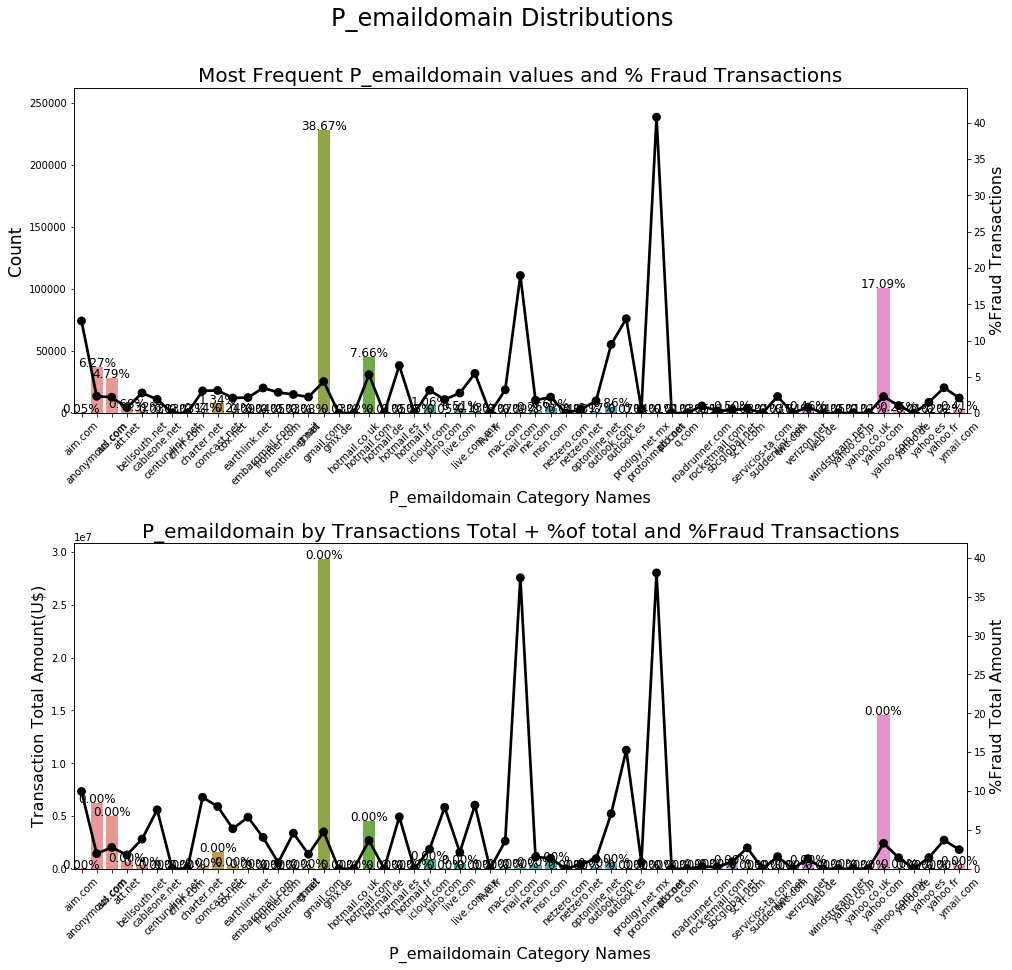

In [10]:
total = len(train)
total_amt = train['TransactionAmt'].sum()
TARGET = 'isFraud'

train['TransactionAmt'] = train['TransactionAmt'].astype('float64')

tmp = pd.crosstab(train['P_emaildomain'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp['count'] = train['P_emaildomain'].value_counts()[tmp['P_emaildomain']].values
tmp['perc'] = train['P_emaildomain'].value_counts()[tmp['P_emaildomain']].values / total * 100
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
print(tmp.sort_values(by='Fraud', ascending=False).head(7))

#df_train['P_emaildomain'] = (df_train['P_emaildomain'] == 'mail.com')
ploting_cnt_amt(train, 'P_emaildomain')

In [8]:
train[train['P_emaildomain'] == 'protonmail.com'].shape

(76, 384)

isFraud   R_emaildomain    NoFraud      Fraud  count      perc
38       protonmail.com   4.878049  95.121951     41  0.006943
29             mail.com  62.295082  37.704918    122  0.020659
33          netzero.net  77.777778  22.222222      9  0.001524
35          outlook.com  83.486239  16.513761   2507  0.424527
36           outlook.es  86.836028  13.163972    433  0.073323
23           icloud.com  87.124464  12.875536   1398  0.236732
16            gmail.com  88.081614  11.918386  57147  9.677075


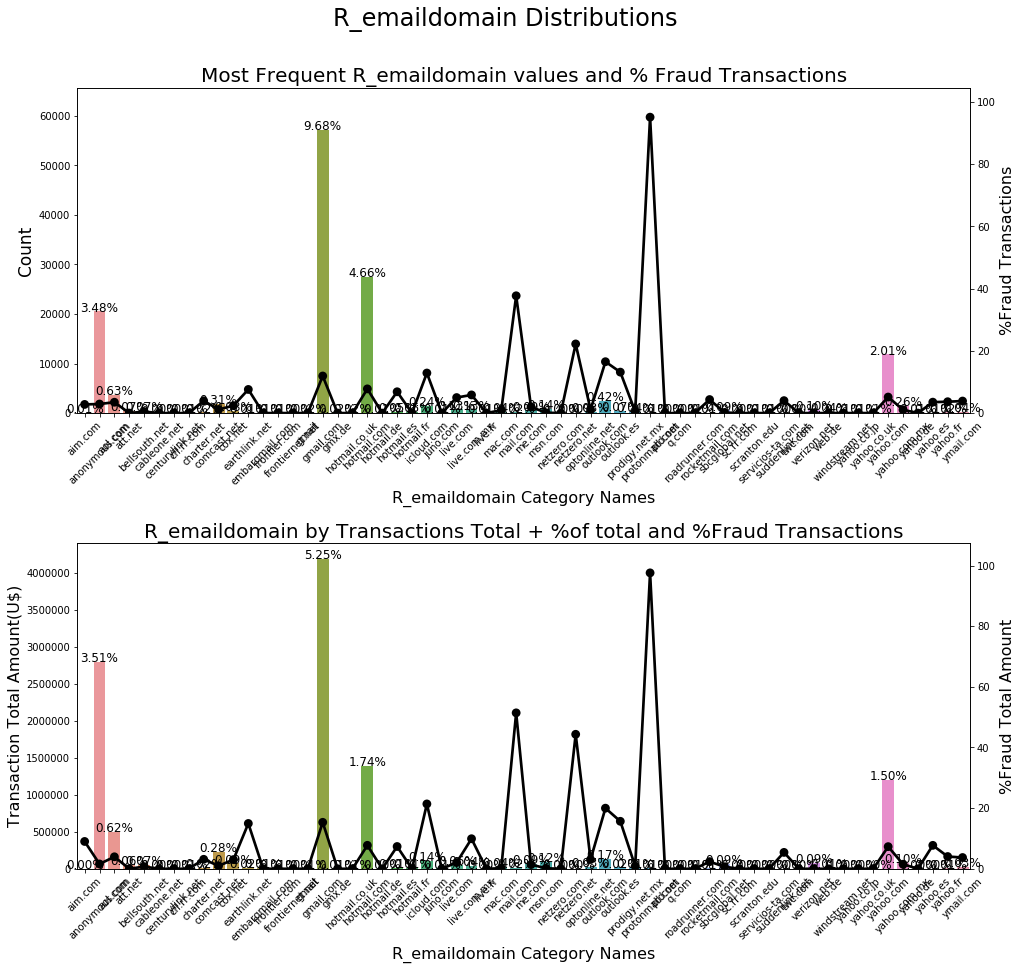

In [27]:
tmp = pd.crosstab(train['R_emaildomain'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp['count'] = train['R_emaildomain'].value_counts()[tmp['R_emaildomain']].values
tmp['perc'] = train['R_emaildomain'].value_counts()[tmp['R_emaildomain']].values / total * 100
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
print(tmp.sort_values(by='Fraud', ascending=False).head(7))

#df_train['P_emaildomain'] = (df_train['P_emaildomain'] == 'mail.com')
ploting_cnt_amt(train, 'R_emaildomain')

In [8]:
train['P_email']=(train['P_emaildomain']=='protonmail.com')
train['R_email']=(train['R_emaildomain']=='protonmail.com')
test['P_email']=(test['P_emaildomain']=='protonmail.com')
test['R_email']=(test['R_emaildomain']=='protonmail.com')

In [11]:
# null인 컬럼 개수를 변수로 생성
train['null'] = train.isna().sum(axis=1)
test['null'] = test.isna().sum(axis=1)

In [12]:
train['null'].head()

0    211
1    204
2    186
3    207
4    129
Name: null, dtype: int64

In [13]:
a = np.zeros(train.shape[0])
train["lastest_browser"] = a
a = np.zeros(test.shape[0])
test["lastest_browser"] = a

#id_31 대체하는 함수
def browser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df

train=browser(train)
test=browser(test)

In [14]:
# email mapping
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']
for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [15]:
category_columns = []

for col in list(train):
    if train[col].dtype=='O':
        print(col)
        category_columns.append(col)
#         train[col] = train[col].fillna('unseen_before_label')
#         test[col]  = test[col].fillna('unseen_before_label')
        
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        
        le = preprocessing.LabelEncoder()
        le.fit(list(train[col])+list(test[col]))
        train[col] = le.transform(train[col])
        test[col]  = le.transform(test[col])
        
#         train[col] = train[col].astype('category')
#         test[col] = test[col].astype('category')

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo
P_emaildomain_bin
P_emaildomain_suffix
R_emaildomain_bin
R_emaildomain_suffix


In [16]:
# 아래 칼럼들의 value_counts를 변수로 생성
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

train['card2_count_full'] = train['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))
test['card2_count_full'] = test['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))

train['card3_count_full'] = train['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))
test['card3_count_full'] = test['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))

train['card4_count_full'] = train['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False))
test['card4_count_full'] = test['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False))

train['card5_count_full'] = train['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False))
test['card5_count_full'] = test['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False))

train['card6_count_full'] = train['card6'].map(pd.concat([train['card6'], test['card6']], ignore_index=True).value_counts(dropna=False))
test['card6_count_full'] = test['card6'].map(pd.concat([train['card6'], test['card6']], ignore_index=True).value_counts(dropna=False))


train['addr1_count_full'] = train['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))
test['addr1_count_full'] = test['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))

train['addr2_count_full'] = train['addr2'].map(pd.concat([train['addr2'], test['addr2']], ignore_index=True).value_counts(dropna=False))
test['addr2_count_full'] = test['addr2'].map(pd.concat([train['addr2'], test['addr2']], ignore_index=True).value_counts(dropna=False))

In [17]:
# 그룹별 mean or std로 나눔
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

In [18]:
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)

train['Transaction_hour_of_day'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour_of_day'] = np.floor(test['TransactionDT'] / 3600) % 24

# decimal -> 소수 부분 * 1000을 int로
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

In [20]:
train['Transaction_day_of_week'].value_counts()

0.0    98502
6.0    86377
3.0    85433
5.0    85356
4.0    84815
1.0    79834
2.0    70223
Name: Transaction_day_of_week, dtype: int64

In [17]:
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = preprocessing.LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))
    
for feature in ['id_01', 'id_31', 'id_33', 'id_35']:
    # Count encoded separately for train and test
    train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
    test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))
    
category_features=["ProductCD","card4", "card6","P_emaildomain","R_emaildomain",
                   "M1","M2","M3","M4","M5","M6","M7","M8","M9",
                   "DeviceType","DeviceInfo",
                   "id_12","id_15","id_16","id_23","id_27","id_28","id_29","id_30",
                   "id_31","id_33",'id_34','id_35','id_36',"id_37","id_38",
                   "P_emaildomain_bin", "P_emaildomain_suffix",
                   "R_emaildomain_bin","R_emaildomain_suffix"]
for c in category_features:
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))

In [20]:
y_train = train['isFraud'].copy()
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

#del train, test

#fill in mean for floats

# for c in X_train.columns:
#     if X_train[c].dtype=='float16' or X_train[c].dtype=='float32' or X_train[c].dtype=='float64':
#         X_train[c].fillna(X_train[c].mean())
#         X_test[c].fillna(X_train[c].mean())

#fill in -999 for categoricals
# X_train = X_train.fillna(-111)
# X_test = X_test.fillna(-111)
# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))

In [21]:
n_fold = 6
folds = KFold(n_splits=n_fold,shuffle=True)

print(folds)

KFold(n_splits=6, random_state=None, shuffle=True)


In [ ]:
%%time

os.environ['KMP_DUPLICATE_LIB_OK']='True'
xgb_sub=sample_submission.copy()
xgb_sub['isFraud'] = 0
from xgboost import XGBClassifier
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train)):
    xgb = XGBClassifier(alpha=4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bynode=1, colsample_bytree=0.9, gamma=0.1,
                    learning_rate=0.05, max_delta_step=0, max_depth=9,
                    min_child_weight=1, missing=np.nan, n_estimators=500, n_jobs=4,
                    nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=None, subsample=0.9, tree_method='hist', verbosity=1
    )
    
    X_train_, X_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    xgb.fit(X_train_,y_train_)
    del X_train_,y_train_
    pred=xgb.predict_proba(X_test)[:,1]
    val=xgb.predict_proba(X_valid)[:,1]
    del xgb, X_valid
    print('ROC accuracy: {}'.format(roc_auc_score(y_valid, val)))
    del val,y_valid
    xgb_sub['isFraud'] = xgb_sub['isFraud']+pred/n_fold
    del pred
    gc.collect()

In [57]:
xgb_sub.to_csv('sub_xgb.csv')
xgb_sub.head()

In [21]:
## LightGBM 이용
import random

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED)
LOCAL_TEST = False
TARGET = 'isFraud'

In [22]:
import lightgbm as lgb

def make_predictions(tr_df, tt_df, features_columns, target, lgb_params, NFOLDS=2):
    folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

    X,y = tr_df[features_columns], tr_df[target]    
    P,P_y = tt_df[features_columns], tt_df[target]  

    tt_df = tt_df[['TransactionID',target]]    
    predictions = np.zeros(len(tt_df))
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print('Fold:',fold_)
        tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
        vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]
            
        print(len(tr_x),len(vl_x))
        tr_data = lgb.Dataset(tr_x, label=tr_y)

        if LOCAL_TEST:
            vl_data = lgb.Dataset(P, label=P_y) 
        else:
            vl_data = lgb.Dataset(vl_x, label=vl_y)  

        estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data, vl_data],
            verbose_eval = 200,
        )   
        
        pp_p = estimator.predict(P)
        predictions += pp_p/NFOLDS

        if LOCAL_TEST:
            feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),X.columns)), columns=['Value','Feature'])
            print(feature_imp)
        
        del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
        gc.collect()
        
    tt_df['prediction'] = predictions
    
    return tt_df

In [23]:
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':800,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                }

In [24]:
test = test.merge(sample_submission, how='left', left_index=True,
                         right_index=True, on='TransactionID')

In [22]:
train['P_email'] = np.where(train['P_email'], 1, 0)
test['P_email'] = np.where(test['P_email'], 1, 0)

In [23]:
print(train['P_email'].value_counts())
print(test['P_email'].value_counts())

0    590464
1        76
Name: P_email, dtype: int64
0    506608
1        83
Name: P_email, dtype: int64


In [26]:
print(train.shape)
print(TARGET)

(590540, 415)
isFraud


In [28]:
%%time
features_columns = list(train)

if LOCAL_TEST:
    lgb_params['learning_rate'] = 0.01
    lgb_params['n_estimators'] = 20000
    lgb_params['early_stopping_rounds'] = 100
    test_predictions = make_predictions(train, test, features_columns, TARGET, lgb_params)
    print(metrics.roc_auc_score(test_predictions[TARGET], test_predictions['prediction']))
else:
    lgb_params['learning_rate'] = 0.005
    lgb_params['n_estimators'] = 1800
    lgb_params['early_stopping_rounds'] = 100    
    test_predictions = make_predictions(train, test, features_columns, TARGET, lgb_params, NFOLDS=2)

Fold: 0
295270 295270
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Fold: 1
295270 295270
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Wall time: 2min 32s


In [25]:
if not LOCAL_TEST:
    test_predictions['isFraud'] = test_predictions['prediction']
    test_predictions[['TransactionID','isFraud']].to_csv('xgver_submission.csv', index=False)

In [26]:
test_predictions['isFraud'].value_counts()

0.040149    506691
Name: isFraud, dtype: int64